<font  style="font-size: 4rem; color: darkviolet"> Convolutional Neural Networks in TensorFlow </font>

AA - 2022/23 - TP7

*This assignement is inspired by the Deep Learning course on Coursera by Andrew Ng, Stanford University, for which we are thankful.*

In this assignment, you will learn how to build and train Convolutional Neural Networks (ConvNets) using TensorFlow Keras API. You will be working on two different tasks. First, you will build a binary classifier using the Sequential API to classify the mood of a given person as either positive or negative. Next, you will build a multiclass classifier using the Functional API to identify sign language digits.

Before starting this assignment, you should have a basic understanding of TensorFlow.

You're encouraged to read the official documentation. You can find the docs for the Sequential and Functional APIs here:

https://www.tensorflow.org/guide/keras/sequential_model

https://www.tensorflow.org/guide/keras/functional


## Table of Contents
- [1 - The Sequential API](#1)
    - [1.1 - The Happy House Dataset](#1.1)
    - [1.2 - Create the Sequential Model](#1.2)
        - [Exercise 1.2.1 - happyModel](#ex-1.2.1)
    - [1.3 - Train and Evaluate the Model](#1.3)
- [2 - The Functional API](#2)
    - [2.1 - The SIGNS Dataset](#2.1)
    - [2.2 - Forward Propagation](#2.2)
        - [Exercise 2.2.1 - convolutional_model](#ex-2.2.1)
    - [2.3 - Train the Model](#2.3)
    - [2.4 - History](#2.4)
- [3 - Exercise - output volume](#ex-3) 

In [ ]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
from data.cnn_utils import *
from data.test_utils import summary, comparator

%matplotlib inline
np.random.seed(1)

# <a name='1'></a>
# <font color='darkviolet'> 1 - The Sequential API

When it comes to practical applications of deep learning, programming frameworks are essential tools that offer a wide range of built-in functions to help you create and train models with ease. One such framework is Keras, which is a high-level abstraction built on top of TensorFlow that provides even more simplified and optimized model building and training.

You'll be using Keras' Sequential API to create a deep learning model. This API allows you to build models layer by layer, and is particularly well-suited for simple tasks where each layer has exactly one input tensor and one output tensor. Using the Sequential API is straightforward and easy to understand, making it a great choice for beginners.

<a name='1.1'></a>
## <font color='darkviolet'> 1.1 - The Happy House dataset

The Happy House dataset comprises images of individuals' faces, and your objective will be to create a ConvNet that can accurately identify whether these individuals are smiling or not. This is an important task because only those who are smiling will be granted entry into the Happy House.

In [ ]:
def load_happy_dataset():
    # Load the training dataset
    train_dataset = h5py.File('data/train_happy.h5', "r")
    
    # Extract the features and labels for the training set
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # labels

    # Load the test dataset
    test_dataset = h5py.File('data/test_happy.h5', "r")
    
    # Extract the features and labels for the test set
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # labels

    # Extract the list of classes
    classes = np.array(test_dataset["list_classes"][:]) 
    
    # Reshape the labels to match the expected shape
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    # Return the dataset as a tuple
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
# Load the Happy House dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset()

# Normalize the image vectors by dividing by 255
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Reshape the labels to match the expected shape (m, 1), where m is the number of examples
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

In [ ]:
# Print the shapes of the datasets and labels
print("Number of training examples = " + str(X_train.shape[0]))
print("Number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

Number of training examples = 600
Number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


#### <font color='blue'> Q1.1 Describe your dataset.

The Happy House dataset is a dataset of images of individuals' faces. It is used for binary classification, where the objective is to determine whether the individuals in the images are smiling or not. The dataset is divided into a training set and a test set.

The training set consists of 600 examples, with images of size 64x64 and 3 color channels (RGB). The features (image vectors) are normalized by dividing by 255 to scale them between 0 and 1. The labels (whether the individuals are smiling or not) are reshaped to have a shape of (600, 1).

The test set consists of 150 examples, with images of the same size and color channels as the training set. The features are also normalized, and the labels are reshaped to have a shape of (150, 1).

The dataset also includes a list of classes, which in this case is binary: "smiling" or "not smiling".

<a name='1.2'></a>
## <font color='darkviolet'> 1.2 - Create the Sequential Model 
    
The **TensorFlow Keras Sequential** API is useful for building simple models where layers are arranged in a sequential order. You can add and remove layers using the `.add()` and `.pop()` methods, respectively. A Sequential model can be thought of as a list of layers, where the order in which they are specified matters. 

In Keras, you must specify the input shape in advance for any layer construction, since the shape of the weights is based on the shape of the inputs. To create a Sequential model, pass a list of layers to the Sequential constructor.

<a name='ex-1.2.1'></a>
### <font color='blue'> Exercise 1.2.1 - happyModel

Implement the `happyModel` function below to build the following model: `ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE`. 
    
Take help from [tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers).

Plug in the following parameters for all the steps:

 - [ZeroPadding2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ZeroPadding2D): padding 3, input shape 64 x 64 x 3
 - [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): Use 32 7x7 filters, stride 1
 - [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization): for axis 3
 - [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU)
 - [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): Using default parameters
 - [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the previous output.
 - Fully-connected ([Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) layer: Apply a fully connected layer with 1 neuron and a sigmoid activation. 
 

In [ ]:
def happyModel():
    """
    Implements the forward propagation for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Arguments:
    None

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    # Define the layers of the model using the Sequential API
    model = tf.keras.Sequential([
        
        # ZeroPadding2D with padding 3, input shape of 64 x 64 x 3
        #TODO
        tf.keras.layers.ZeroPadding2D(padding=(3, 3), input_shape=(64, 64, 3)),
        
        # Conv2D with 32 7x7 filters and stride of 1
        #TODO
        tf.keras.layers.Conv2D(32, (7, 7), strides=(1, 1)),

        
        # BatchNormalization for axis 3
        #TODO
        tf.keras.layers.BatchNormalization(axis=3),

        
        # ReLU
        #TODO
        tf.keras.layers.ReLU(),

        
        # Max Pooling 2D with default parameters
        #TODO
        tf.keras.layers.MaxPooling2D(),

        
        # Flatten layer
        #TODO
        tf.keras.layers.Flatten(),

        
        # Dense layer with 1 unit & 'sigmoid' activation
        #TODO
        tf.keras.layers.Dense(1, activation='sigmoid')

    ])
    
    # Return the model
    return model


In [ ]:
happy_model = happyModel()
# Print a summary for each layer
for layer in summary(happy_model):
    print(layer)
    
output = [['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))],
            ['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform'],
            ['BatchNormalization', (None, 64, 64, 32), 128],
            ['ReLU', (None, 64, 64, 32), 0],
            ['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid'],
            ['Flatten', (None, 32768), 0],
            ['Dense', (None, 1), 32769, 'sigmoid']]
    
comparator(summary(happy_model), output)

['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))]
['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform']
['BatchNormalization', (None, 64, 64, 32), 128]
['ReLU', (None, 64, 64, 32), 0]
['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid']
['Flatten', (None, 32768), 0]
['Dense', (None, 1), 32769, 'sigmoid']
All tests passed!


After creating a deep learning model, the next step is to compile it for training by specifying an optimizer and loss function. In addition, you can also specify metrics such as accuracy to track during training.

In [ ]:
happy_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [ ]:
happy_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 70, 70, 3)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        4736      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                        

#### <font color='blue'> Q1.2.1 What is the difference between trainable and non-trainable parameters in a deep learning model?

Trainable parameters in a deep learning model are the parameters that are learned during the training process to optimize the model's performance. These parameters are updated iteratively during training through gradient descent or other optimization algorithms to minimize the loss function.

Non-trainable parameters, on the other hand, are fixed parameters that are not updated during training. These parameters are typically used in pre-trained models, such as pre-trained convolutional neural networks (CNNs) where the weights of the convolutional layers are already learned from large datasets and are kept fixed during fine-tuning on a smaller dataset.

In the summary of the model provided, the total parameters are 37,633, out of which 37,569 are trainable parameters that will be updated during training, and 64 are non-trainable parameters that are fixed.

#### <font color='blue'> Q1.2.2 How to compute the number of parameters reported per layer? Can you identify the origin of the 64 non-trainable parameters?

The number of parameters reported per layer in the model summary can be calculated based on the type of layer and its configuration. For example:

    For a Conv2D layer, the number of parameters can be calculated as (filter_height * filter_width * input_channels + 1) * output_channels, where filter_height and filter_width are the dimensions of the convolutional kernel, input_channels is the number of input channels to the layer, and output_channels is the number of output channels or filters in the layer. The "+1" accounts for the bias term.

    For a Dense layer, the number of parameters can be calculated as input_dim * output_dim + output_dim, where input_dim is the number of input units to the layer and output_dim is the number of output units or neurons in the layer. The "+output_dim" accounts for the bias term.

    For a BatchNormalization layer, the number of parameters can be calculated as 4 * output_dim, where output_dim is the number of output units in the layer. BatchNormalization has 4 parameters per feature map: gamma (scaling factor), beta (shifting factor), moving mean, and moving variance.

The origin of the 64 non-trainable parameters reported in the model summary may depend on the specific architecture and configuration of the model. It's possible that these non-trainable parameters are related to some fixed parameters or weights used in the model, such as fixed biases or normalization parameters. Without further information about the model architecture and configuration, it's not possible to definitively identify the exact origin of these non-trainable parameters.
        
#### <font color='blue'> Q1.2.3 You can note that the first output dimension of a layers is *None*. Can you explain why this is the case?

In the model summary, the first output dimension of each layer is usually shown as "None" because it represents the batch size, which can vary during training or inference. The batch size is the number of samples processed in each iteration during training or inference, and it can be different for different input data batches.

During model compilation, the batch size is not specified as it can be flexible and determined at runtime depending on the input data. Therefore, the first output dimension of each layer in the model summary is shown as "None" to indicate that it can vary depending on the batch size used during actual training or inference.

The "None" value in the first output dimension of a layer in the model summary is a placeholder that indicates that the actual value will be determined during runtime based on the batch size used for training or inference. Once the batch size is known during runtime, the "None" value will be replaced with the actual batch size, and the model will process the input data accordingly.

<a name='1.3'></a>
## <font color='darkviolet'> 1.3 - Train and Evaluate the Model

Once you've created and compiled your model, and verified its structure using `model.summary()`, it's time to start training. Simply call `.fit()` to begin the training process.

One of the advantages of using TensorFlow is that it automates many of the tedious and complex aspects of machine learning, such as backpropagation. You do have the option to specify the number of epochs and the size of the mini-batch. 

In [ ]:
happy_model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
19/19 [==============================] - 5s 220ms/step - loss: 1.9937 - accuracy: 0.6150
Epoch 2/10
19/19 [==============================] - 3s 173ms/step - loss: 0.3603 - accuracy: 0.8333
Epoch 3/10
19/19 [==============================] - 3s 169ms/step - loss: 0.2798 - accuracy: 0.8883
Epoch 4/10
19/19 [==============================] - 4s 216ms/step - loss: 0.1326 - accuracy: 0.9467
Epoch 5/10
19/19 [==============================] - 3s 173ms/step - loss: 0.1024 - accuracy: 0.9600
Epoch 6/10
19/19 [==============================] - 3s 172ms/step - loss: 0.1055 - accuracy: 0.9633
Epoch 7/10
19/19 [==============================] - 3s 170ms/step - loss: 0.1111 - accuracy: 0.9583
Epoch 8/10
19/19 [==============================] - 4s 213ms/step - loss: 0.0786 - accuracy: 0.9767
Epoch 9/10
19/19 [==============================] - 3s 171ms/step - loss: 0.0571 - accuracy: 0.9833
Epoch 10/10
19/19 [==============================] - 3s 172ms/step - loss: 0.0476 - accuracy: 0.9917

#### <font color='blue'> Q1.3.1 What does each output line indicate ?


After training your model using `.fit()`, you can evaluate its performance on your test set by calling `.evaluate()`. This function returns the value of the **loss function** and any **performance metrics** you specified during compilation. In this case, the loss function used was binary_crossentropy and the metric used was accuracy.

In [ ]:
happy_model.evaluate(X_test, Y_test)

5/5 [==============================] - 0s 44ms/step - loss: 0.3353 - accuracy: 0.8133


[0.33529236912727356, 0.8133333325386047]

<a name='2'></a>
# <font color='darkviolet'> 2 - The Functional API

The [Functional API](https://www.tensorflow.org/guide/keras/functional) in TensorFlow can handle more complex models than the Sequential API, allowing for shared layers, and layers with multiple inputs or outputs. 
One example of a more complex layer connection is a skip connection, which skips some layers in the network and feeds the output directly to a later layer in the network.
    
You will use Keras flexible Functional API to build a ConvNet that can differentiate between 6 sign language digits. 

<a name='2.1'></a>
## <font color='darkviolet'> 2.1 - The SIGNS Dataset

The SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

In [ ]:
def load_signs_dataset():
    # Load the training dataset
    train_dataset = h5py.File('data/train_signs.h5', "r")
    
    # Extract the features and labels for the training set
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # labels

    # Load the test dataset
    test_dataset = h5py.File('data/test_signs.h5', "r")
    
    # Extract the features and labels for the test set
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # labels

    # Extract the list of classes
    classes = np.array(test_dataset["list_classes"][:]) 
    
    # Reshape the labels to match the expected shape
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    # Return the dataset as a tuple
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

y = 4


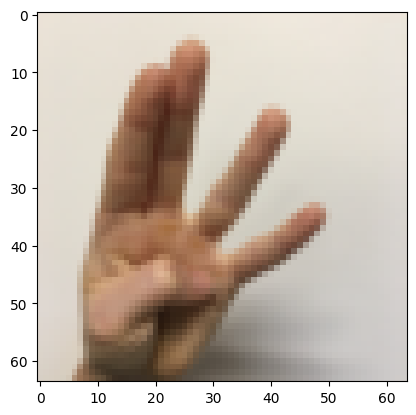

In [ ]:
# Example of an image from the dataset
index = 9
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [ ]:
# Normalize the pixel values of the images by dividing each pixel value by 255
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert the target labels to one-hot vectors
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


#### <font color='blue'> Q2.1.1 Describe your dataset.

This dataset consists of 1200 image examples with dimensions of 64 x 64 pixels and 3 color channels (RGB). The dataset is split into training and test sets with 1080 and 120 examples respectively. The labels are represented in a one-hot encoded format with 6 categories. The dataset is designed for a classification task where the goal is to classify each image into one of the 6 categories.

<a name='2.2'></a>
### <font color='darkviolet'> 2.2 - Forward Propagation

In TensorFlow, there are built-in functions that implement the convolution steps. By now, you should be familiar with how TensorFlow builds computational graphs. In the [Functional API](https://www.tensorflow.org/guide/keras/functional), you create a graph of layers. This is what allows such great flexibility.

However, the following model could also be defined using the Sequential API since the information flow is on a single line. Anyhw, we want you to learn to use the Functional API.

Begin building your graph of layers by creating an input node as a callable object:

- **input_img = tf.keras.Input(shape=input_shape):** 

Then, create a new node in the graph of layers by calling a layer on the `input_img` object: 

- **tf.keras.layers.Conv2D(filters= ... , kernel_size= ... , padding='same')(input_img):** Read the full documentation on [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).

- **tf.keras.layers.MaxPool2D(pool_size=(f, f), strides=(s, s), padding='same'):** `MaxPool2D()` downsamples your input using a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window.  For max pooling, you usually operate on a single example at a time and a single channel at a time. Read the full documentation on [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D).

- **tf.keras.layers.ReLU():** computes the element-wise ReLU of Z (which can be any shape). You can read the full documentation on [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU).

- **tf.keras.layers.Flatten()**: given a tensor "P", this function takes each training (or test) example in the batch and flattens it into a 1D vector.  

    * If a tensor P has the shape (batch_size,h,w,c), it returns a flattened tensor with shape (batch_size, k), where $k=h \times w \times c$.  "k" equals the product of all the dimension sizes other than the first dimension.
    
    * For example, given a tensor with dimensions [100, 2, 3, 4], it flattens the tensor to be of shape [100, 24], where 24 = 2 * 3 * 4.  You can read the full documentation on [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten).

- **tf.keras.layers.Dense(units= ... , activation='softmax')(F):** given the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation on [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).

In the last function above (`tf.keras.layers.Dense()`), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize those weights when initializing the parameters.

Lastly, before creating the model, you'll need to define the output using the last of the function's compositions (in this example, a Dense layer): 

- **outputs = tf.keras.layers.Dense(units=6, activation='softmax')(F)** 


<a name='ex-2.2.1'></a>
### <font color='blue'> Exercise 2.2.1 - convolutional_model

Implement the `convolutional_model` function below to build the following model: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE`. Use the functions above! 

Also, plug in the following parameters for all the steps:

 - [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): Use 8 filters 4 by 4 , stride 1, padding is "SAME"
 - [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU)
 - [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
 - **Conv2D**: Use 16 filters 2 by 2, stride 1, padding is "SAME"
 - **ReLU**
 - **MaxPool2D**: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
 - [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the previous output.
 - Fully-connected ([Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) layer: apply a fully connected layer with 6 neurons and a softmax activation. 

In [ ]:
def convolutional_model(input_shape):
    """
    Implements a convolutional neural network model using Keras.

    Arguments:
    input_shape -- shape of the input data

    Returns:
    model -- Keras model instance
    """
    
    # Define the input layer
    input_img = tf.keras.Input(shape=input_shape)
    
    # CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    conv1 = tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 4), strides=(1, 1), padding='SAME')(input_img)
    
    # Apply ReLU activation function
    relu1 = tf.keras.layers.ReLU()(conv1)
    
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    maxpool1 = tf.keras.layers.MaxPool2D(pool_size=(8, 8), strides=(8, 8), padding='SAME')(relu1)
    
    # CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    conv2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(2, 2), strides=(1, 1), padding='SAME')(maxpool1)
    
    # Apply ReLU activation function
    relu2 = tf.keras.layers.ReLU()(conv2)
    
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    maxpool2 = tf.keras.layers.MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='SAME')(relu2)
    
    # Flatten
    flatten = tf.keras.layers.Flatten()(maxpool2)
    
    # Dense layer
    out = tf.keras.layers.Dense(units=6, activation='softmax')(flatten)
    
    # Define the Keras model
    model = tf.keras.Model(inputs=input_img, outputs=out)
    
    return model


In [ ]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()
    
output = [['InputLayer', [(None, 64, 64, 3)], 0],
        ['Conv2D', (None, 64, 64, 8), 392, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 64, 64, 8), 0],
        ['MaxPooling2D', (None, 8, 8, 8), 0, (8, 8), (8, 8), 'same'],
        ['Conv2D', (None, 8, 8, 16), 528, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 8, 8, 16), 0],
        ['MaxPooling2D', (None, 2, 2, 16), 0, (4, 4), (4, 4), 'same'],
        ['Flatten', (None, 64), 0],
        ['Dense', (None, 6), 390, 'softmax']]
    
comparator(summary(conv_model), output)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         392       
                                                                 
 re_lu_1 (ReLU)              (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          528       
                                                                 
 re_lu_2 (ReLU)              (None, 8, 8, 16)          0         
                                                             

Both the Sequential and Functional APIs return a TF Keras model object. The only difference is how inputs are handled inside the object model.

#### <font color='blue'> Q2.2.1 How to compute the number of parameters reported per layer? 

The number of parameters reported per layer is computed as the sum of the parameters for each trainable variable in the layer. In a convolutional layer, the number of parameters is given by the formula (kernel_height x kernel_width x input_channels x num_filters) + num_filters, where kernel_height and kernel_width are the height and width of the convolutional filter, input_channels is the number of channels in the input tensor, and num_filters is the number of filters in the layer. In a dense layer, the number of parameters is given by (input_size x num_neurons) + num_neurons, where input_size is the size of the input tensor and num_neurons is the number of neurons in the layer.

<a name='2.3'></a>
### <font color='darkviolet'> 2.3 - Train the Model

In [ ]:
# create train and test datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)

In [ ]:
# Print the size of the train_dataset
train_size = tf.data.experimental.cardinality(train_dataset).numpy()
print('Number of batches in train_dataset:', train_size)
print('Number of samples in train_dataset:', train_size * 64)

# Print the size of the test_dataset
test_size = tf.data.experimental.cardinality(test_dataset).numpy()
print('Number of batches in test_dataset:', test_size)
print('Number of samples in test_dataset:', test_size * 64)

Number of batches in train_dataset: 17
Number of samples in train_dataset: 1088
Number of batches in test_dataset: 2
Number of samples in test_dataset: 128


In [ ]:
# Print the contents of the first batch of the train_dataset
for X, Y in train_dataset.take(1):
    print('Shape of input features (X):', X.shape)
    print('Shape of labels (Y):', Y.shape)
    print('Input features (X):', X)
    print('Labels (Y):', Y)

Shape of input features (X): (64, 64, 64, 3)
Shape of labels (Y): (64, 6)
Input features (X): tf.Tensor(
[[[[0.89019608 0.8627451  0.83921569]
   [0.89019608 0.86666667 0.84313725]
   [0.89019608 0.87058824 0.84313725]
   ...
   [0.90980392 0.90196078 0.87843137]
   [0.90588235 0.89803922 0.87058824]
   [0.90196078 0.89803922 0.86666667]]

  [[0.89019608 0.86666667 0.83921569]
   [0.89019608 0.86666667 0.84313725]
   [0.89411765 0.86666667 0.84313725]
   ...
   [0.90980392 0.90196078 0.87843137]
   [0.90588235 0.89803922 0.87058824]
   [0.90588235 0.89803922 0.86666667]]

  [[0.89019608 0.86666667 0.83921569]
   [0.89019608 0.86666667 0.83921569]
   [0.89019608 0.86666667 0.84313725]
   ...
   [0.90980392 0.90196078 0.87843137]
   [0.90588235 0.89803922 0.8745098 ]
   [0.90196078 0.89803922 0.86666667]]

  ...

  [[0.46666667 0.31764706 0.2       ]
   [0.48627451 0.33333333 0.21568627]
   [0.49803922 0.34117647 0.22745098]
   ...
   [0.82352941 0.82745098 0.82745098]
   [0.82745098 0.8

In [ ]:
# Compile the model
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Train the model
history = conv_model.fit(train_dataset,
                          epochs=100,
                          validation_data=test_dataset,
                          verbose=2)

Epoch 1/100
17/17 - 4s - loss: 1.8275 - accuracy: 0.1537 - val_loss: 1.7846 - val_accuracy: 0.1667 - 4s/epoch - 238ms/step
Epoch 2/100
17/17 - 3s - loss: 1.7882 - accuracy: 0.1935 - val_loss: 1.7783 - val_accuracy: 0.2917 - 3s/epoch - 167ms/step
Epoch 3/100
17/17 - 3s - loss: 1.7821 - accuracy: 0.2269 - val_loss: 1.7734 - val_accuracy: 0.2750 - 3s/epoch - 178ms/step
Epoch 4/100
17/17 - 3s - loss: 1.7778 - accuracy: 0.2250 - val_loss: 1.7693 - val_accuracy: 0.3083 - 3s/epoch - 194ms/step
Epoch 5/100
17/17 - 3s - loss: 1.7740 - accuracy: 0.2694 - val_loss: 1.7655 - val_accuracy: 0.3417 - 3s/epoch - 166ms/step
Epoch 6/100
17/17 - 1s - loss: 1.7692 - accuracy: 0.2898 - val_loss: 1.7601 - val_accuracy: 0.4083 - 1s/epoch - 88ms/step
Epoch 7/100
17/17 - 2s - loss: 1.7640 - accuracy: 0.3009 - val_loss: 1.7547 - val_accuracy: 0.3833 - 2s/epoch - 90ms/step
Epoch 8/100
17/17 - 2s - loss: 1.7579 - accuracy: 0.3167 - val_loss: 1.7486 - val_accuracy: 0.3833 - 2s/epoch - 91ms/step
Epoch 9/100
17/17 -

<a name='2.4'></a>
### <font color='darkviolet'> 2.4 - History

The history object is an output of the `.fit()` operation, and provides a record of all the loss and metric values in memory. It's stored as a dictionary that you can retrieve at `history.history`:

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

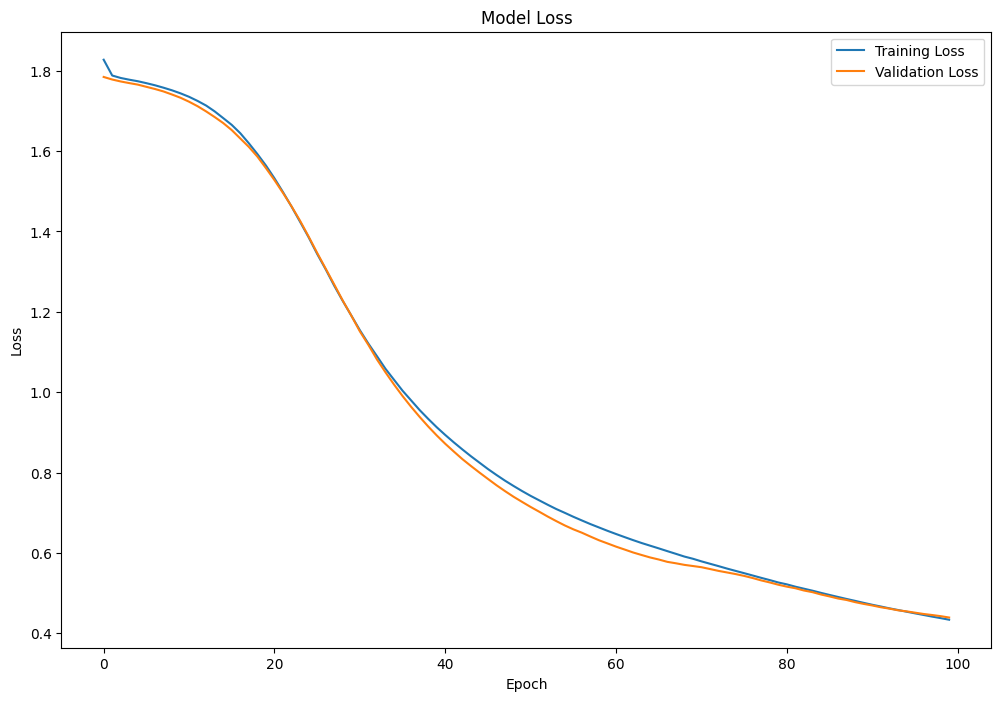

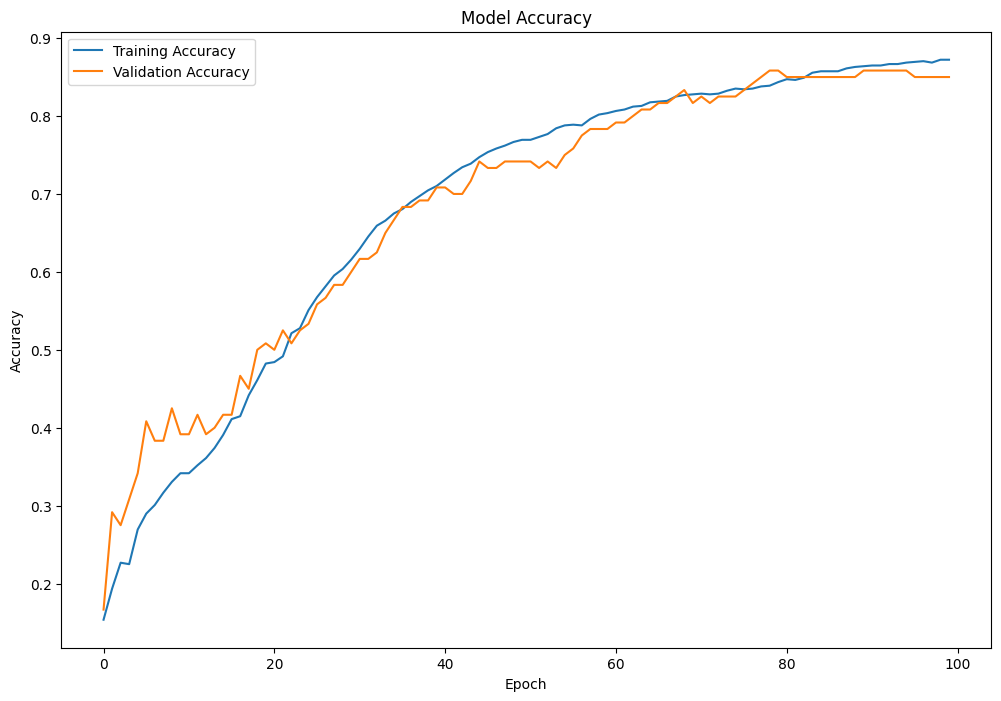

In [30]:
# Create a DataFrame with the loss and accuracy values
df_loss_acc = pd.DataFrame(history.history)

# Extract the training and validation loss values and rename the columns
df_loss = df_loss_acc[['loss', 'val_loss']]
df_loss = df_loss.rename(columns={'loss': 'Training Loss', 'val_loss': 'Validation Loss'})

# Extract the training and validation accuracy values and rename the columns
df_acc = df_loss_acc[['accuracy', 'val_accuracy']]
df_acc = df_acc.rename(columns={'accuracy': 'Training Accuracy', 'val_accuracy': 'Validation Accuracy'})

# Plot the training and validation loss values
df_loss.plot(title='Model Loss', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Loss')

# Plot the training and validation accuracy values
df_acc.plot(title='Model Accuracy', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Accuracy')

#### <font color='blue'> Q2.4.1 Observe your training history and describe.

Loss is decreasing while accuracy is increasing.

<a name='ex-3'></a>
### <font color='blue'> Exercise 3 - output volume computation
    
You have an input volume that is 32 x 32 x 16, and apply max pooling with a stride of 2 and a filter size of 2.
    
What is the output volume?

Given an input volume of size 32 x 32 x 16 and applying max pooling with a stride of 2 and a filter size of 2, the output volume can be calculated as follows:

    Spatial dimensions (width and height):
    The formula to calculate the output spatial dimensions after max pooling is:
    Output Width/Height = (Input Width/Height - Filter Size) / Stride + 1

In this case, the input width and height are both 32, the filter size is 2, and the stride is 2. Plugging these values into the formula:

Output Width/Height = (32 - 2) / 2 + 1
Output Width/Height = 30 / 2 + 1
Output Width/Height = 15 + 1
Output Width/Height = 16

So, the output width and height after max pooling would be 16 x 16.

    Depth (number of channels):
    The depth of the output volume remains the same as the depth of the input volume, which is 16 in this case.

Putting it all together, the output volume after max pooling with a stride of 2 and a filter size of 2 would be 16 x 16 x 16.